In [1]:
import torch
import torch.nn as nn
import torch.optim as  optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets , transforms
from torch.utils.data import DataLoader

MLP…多層パーセプトロン<br>
ミニバッチ学習を行う。今回は100枚ごとに学習を行っていく。<br>
view(バッチサイズ,-1)でimgsが(B,C,H,W）のTensorであったのが、（B、C*H*W）に変換される。

In [3]:
#GPUが使えるかどうかの確認を行う。

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#前処理の定義を行っていく
transform = transforms.Compose([
                               transforms.ToTensor()#これで画像をTensorクラスに変換することが出来る。さらにChannelLastをChannelFirstに変換して０～255の数値を０～１に変換してくれる
                                
])

#'./data'ここにデータが保存される。
#訓練時にはtrain=Trueにする
#transformには定義した前処理の方法を入れる
train_dataset = datasets.MNIST(root='./data',train = True ,download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
#ミニバッチを定義する
num_batches = 100

In [6]:
#train_datasetには画像のデータがすべて入っている。
#DataLoaderを使用する事によって
#シャッフルしてミニバッチごとにデータをまとめているといった感じ。
train_dataloader = DataLoader(train_dataset , batch_size=num_batches , shuffle = True)

In [11]:
train_iter = iter(train_dataloader)

In [12]:
imgs , labels = train_iter.next()

In [13]:
imgs.size()#バッチの数、チャネルの数、縦、横

torch.Size([100, 1, 28, 28])

In [14]:
labels

tensor([7, 3, 9, 2, 1, 3, 9, 4, 2, 0, 2, 7, 1, 9, 0, 1, 7, 1, 1, 1, 2, 2, 9, 9,
        1, 3, 7, 1, 9, 0, 3, 4, 3, 6, 4, 0, 1, 2, 8, 0, 0, 6, 8, 4, 3, 2, 3, 0,
        1, 6, 6, 2, 3, 8, 1, 2, 0, 3, 5, 9, 0, 1, 1, 7, 6, 7, 8, 7, 1, 7, 8, 7,
        7, 5, 4, 1, 9, 7, 2, 9, 4, 6, 4, 6, 4, 4, 6, 5, 3, 2, 5, 8, 7, 9, 1, 4,
        0, 9, 9, 2])

In [15]:
#一番最初の画像を保存する。
img = imgs[0]

In [17]:
img.size()

torch.Size([1, 28, 28])

In [18]:
#今チャネルFirstの形になっているので
#チャネルLastの形に戻す。

img_permute = img.permute(1,2,0)#軸の順番を入れ替えることが出来る。
img_permute.size()

torch.Size([28, 28, 1])

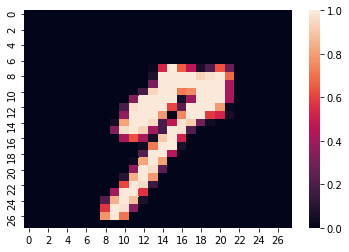

In [20]:
#二次元の配列で渡さなければならない！！
#numpyの型に直してもう一度行ってみる。
sns.heatmap(img_permute.numpy()[:,:,0])

In [21]:
labels[0]

tensor(7)

# モデルの作成を行ってみる。


In [23]:
class MLP(nn.Module):
    #変数定義
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(#Sequentialを使用して多層パーセプトロンを定義する
            #たくさんのLinearを積み上げて行っていく。
            nn.Linear(28 * 28, 400),#最初は入力数、あとは出力数
            nn.ReLU(inplace=True),#inplace=Trueをすることによって、実行した後、その値で元の配列を置き換える。これによってメモリを少しだけ節約することが出来る。
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )
    #順伝番の定義を行う。
    def forward(self , x):#forwardにはselfと入力値ｘを渡す。
        output = self.classifier(x)#先ほど定義したニューラルネットワークに入力値を入れる。
        return output#outputに10個の出力が返ってくる。


In [24]:
#モデルのインスタンス化
model = MLP()

In [25]:
#GPUを使用できるように設定を行う。
model = MLP()
model.to(device)

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [26]:
#損失関数を定義する
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001)

In [38]:
num_epochs = 15
losses = []
accs = []
for epoch in range(num_epochs):#エポックの数だけ回す！
    running_loss = 0.0
    running_acc = 0.0
    for imgs , labels in train_dataloader:#ミニバッチごとに回す(6万個のデータを100のバッチで回すので600回ループすることになる。)
        #imgs,labelsにはそれぞれ100個入っている。
        imgs = imgs.view(num_batches , -1)#torch.Size([100, 1, 28, 28])→torch.Size([100, 784])に変換している
        imgs = imgs.to(device)#imgsをGPUに送っている。
        labels = labels.to(device)#labelsも同じように行う。

        #勾配の初期化
        optimizer.zero_grad()

        #予測
        output = model(imgs)

        #損失関数  
        loss = criterion(output , labels)

        #損失の値を保存
        running_loss += loss.item()

        #アウトプットが最大である場所を返している。
        #predとlabelの値が正しく一致していればOK
        pred = torch.argmax(output , dim = 1)

        #labelsとpredが同じである
        #pred.eq(labels).float()は正解だったら１、不正解だったら0で返すtensor([1., 1., 1., 1., 1., 1., 1., 0.])こんな感じで
        running_acc += torch.mean(pred.eq(labels).float())

        #誤差逆伝播
        loss.backward()

        #重みの更新
        optimizer.step()
    running_loss /= len(train_dataloader)#600で割っている。
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    print("epoch;{} , loss: {} , acc:{}".format(epoch ,running_loss , running_acc))
    



epoch;0 , loss: 0.3087193173666795 , acc:0.9104838371276855
epoch;1 , loss: 0.10869506823519866 , acc:0.9667333960533142
epoch;2 , loss: 0.07267277831056465 , acc:0.977866530418396
epoch;3 , loss: 0.05427126534632407 , acc:0.9830490350723267
epoch;4 , loss: 0.03876227971185775 , acc:0.9878488183021545
epoch;5 , loss: 0.03151244316085164 , acc:0.9901151657104492
epoch;6 , loss: 0.026045338897383773 , acc:0.9911651015281677
epoch;7 , loss: 0.02411091883048357 , acc:0.9918820261955261
epoch;8 , loss: 0.018370700172842286 , acc:0.9937483668327332
epoch;9 , loss: 0.01599569024062172 , acc:0.9946320056915283
epoch;10 , loss: 0.017007132997568987 , acc:0.994482159614563
epoch;11 , loss: 0.015609074556620422 , acc:0.9949327111244202
epoch;12 , loss: 0.011300760342419381 , acc:0.9966487884521484
epoch;13 , loss: 0.010677504230167566 , acc:0.9966655969619751
epoch;14 , loss: 0.011717666566682964 , acc:0.9963821768760681


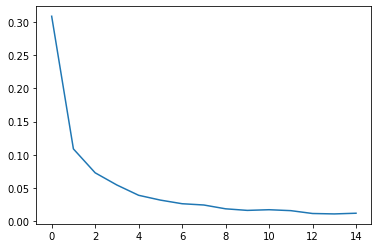

In [39]:
plt.plot(losses)

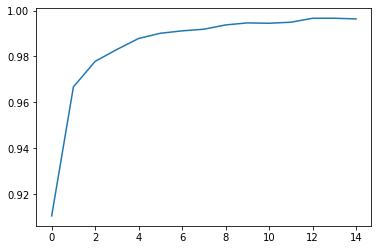

In [40]:
plt.plot(accs)

In [50]:
train_iter = iter(train_dataloader)

In [51]:
imgs , labels = train_iter.next()

In [52]:
labels

tensor([4, 3, 3, 8, 1, 3, 4, 4, 8, 9, 2, 3, 7, 8, 9, 1, 5, 2, 8, 2, 3, 6, 0, 7,
        7, 6, 1, 1, 5, 7, 3, 0, 9, 7, 5, 9, 3, 3, 0, 6, 4, 7, 5, 0, 3, 2, 8, 2,
        9, 1, 8, 7, 4, 1, 3, 2, 7, 1, 9, 9, 4, 1, 9, 3, 6, 4, 8, 7, 3, 4, 0, 8,
        8, 9, 5, 4, 3, 3, 2, 0, 4, 4, 0, 1, 7, 5, 6, 1, 5, 1, 9, 7, 1, 4, 2, 4,
        4, 1, 9, 3])

In [53]:
#modelはGPU上にあるため、imgのデータもGPUに送る
imgs_gpu = imgs.view(100 , -1).to(device)

In [54]:
#予測するときはバッチごと入れてもいい！！
output = model(imgs_gpu)

In [55]:
pred = torch.argmax(output , dim=1)

In [56]:
pred

tensor([4, 3, 3, 8, 1, 3, 4, 4, 8, 9, 2, 3, 7, 8, 9, 1, 5, 2, 8, 2, 3, 6, 0, 7,
        7, 6, 1, 1, 5, 7, 3, 0, 9, 7, 5, 9, 3, 3, 0, 6, 4, 7, 5, 0, 3, 2, 8, 2,
        9, 1, 8, 7, 4, 1, 3, 2, 7, 1, 9, 9, 4, 1, 9, 3, 6, 4, 8, 7, 3, 4, 0, 8,
        8, 9, 5, 4, 3, 3, 2, 2, 4, 4, 0, 1, 7, 5, 6, 1, 5, 1, 9, 7, 1, 4, 2, 4,
        4, 1, 9, 3], device='cuda:0')

In [58]:
pred.eq(labels.to(device)).float()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [66]:
#もちろん一つを予測することも可能
img = imgs.view(100 , -1).to(device)[1]
output = model(img)
pred = torch.argmax(output)
print(pred)
print(labels[1])

tensor(3, device='cuda:0')
tensor(3)


# モデルを保存する方法！

In [67]:
#パラメータを取得する。
params = model.state_dict()

In [68]:
torch.save(params , "model.prm")

In [69]:
!ls

data  model.prm  sample_data


# モデルを読み込む方法


In [70]:
param_load = torch.load("model.prm")

In [71]:
model.load_state_dict(param_load)
'''
#注意！！
この保存したパラメータを使用して学習を行っていくには
model = MLP()
このようにインスタンス化したものに対してパラメータをロードしていく必要がある。
このインスタンス化したものに対して
model.load_state_dict(param_load)
を行うことによって
modelにパラメータが与えられ
output = model(img)
pred = torch.argmax(output)
このようにして予測を行うことが出来る。！！
'''

<All keys matched successfully>